In [1]:
import pickle
import geopandas as gpd
import folium
import random
import pandas as pd
import json
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="darkgrid", palette = "bright", font = "Helvetica")

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load the geometry data for areas
gdf_shp_areas = gpd.read_file("./data/block_groups_shapefiles_with_population.gpkg", layer="areas")
gdf_shp_areas.area_demand = gdf_shp_areas.area_demand.astype(int)

## Elasticity Analysis

### Budget | Coverage

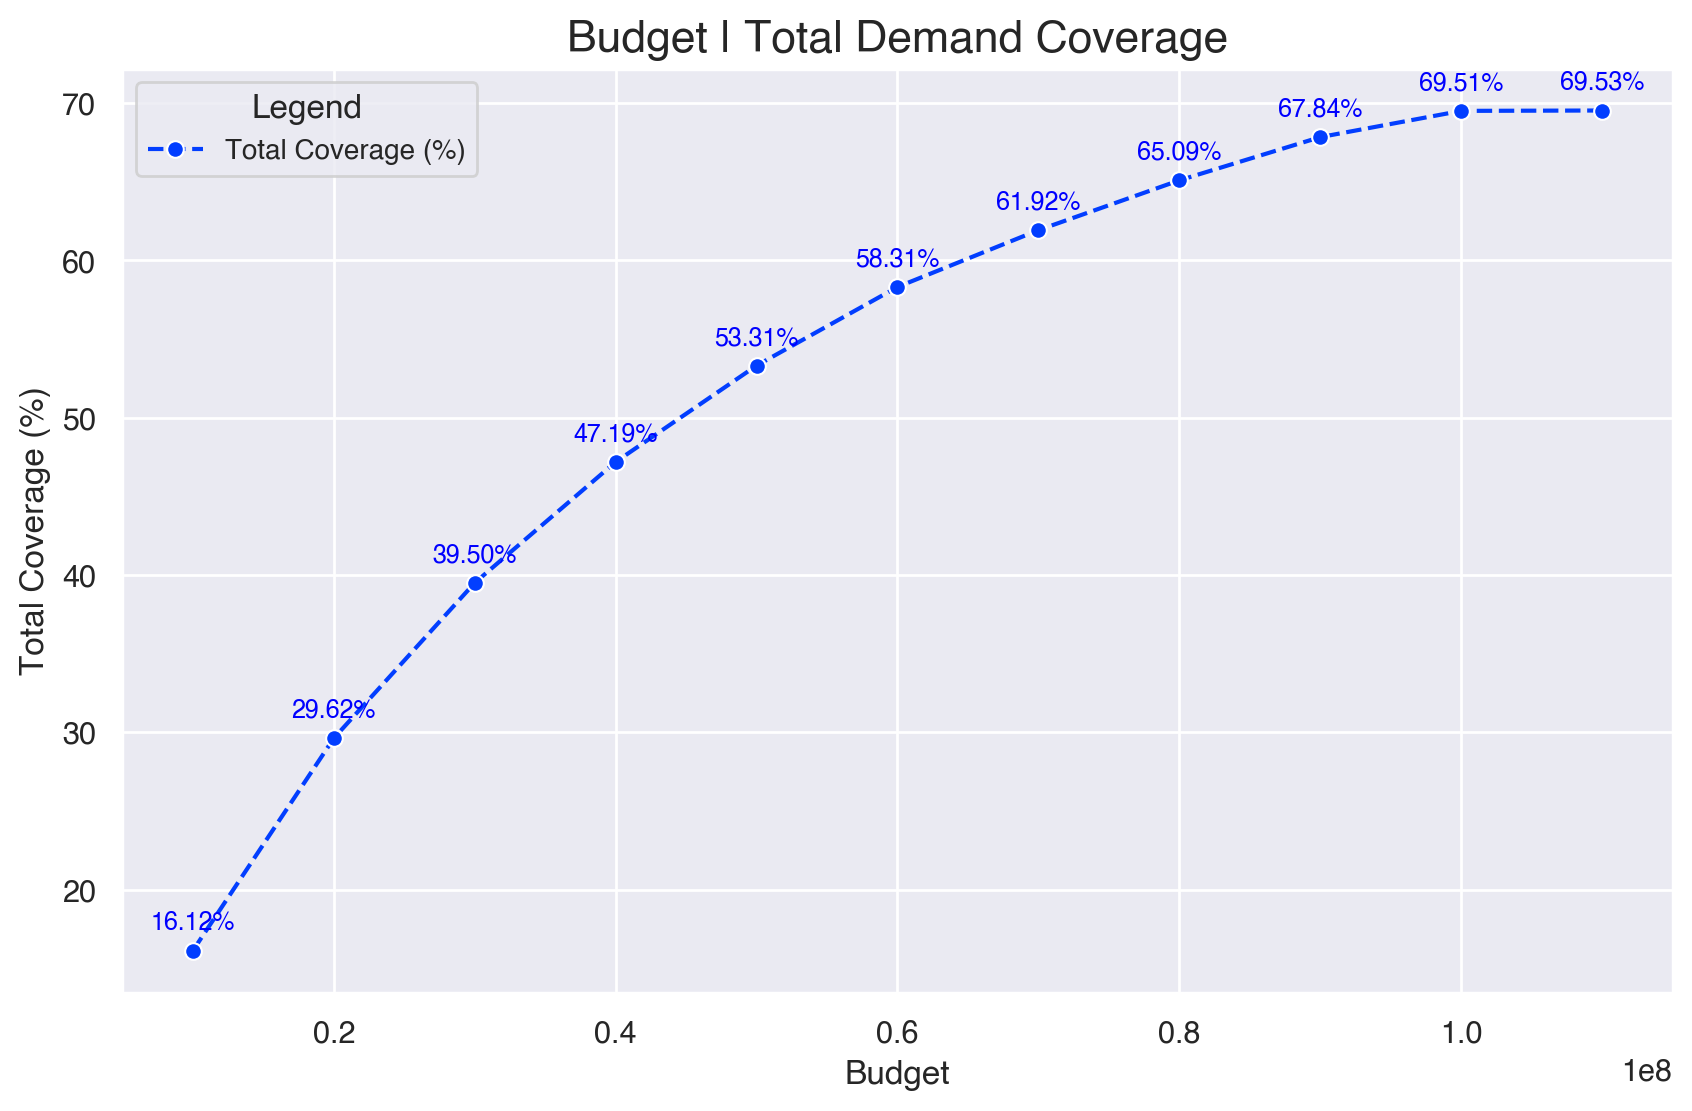

Plot saved as './data/ipynb_plots_saved/budget_total_coverage_curve.png'.


In [15]:
# Load results from JSON file
input_file = "./data/model_results_totals.json"
with open(input_file, "r") as f:
    results = json.load(f)

# Extract budgets, absolute coverages, and percentages
budgets = [entry["budget"] for entry in results]
coverage_percentages = [entry["total_coverage_percentage"] for entry in results]

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=budgets, y=coverage_percentages, marker="o", linestyle="--", label="Total Coverage (%)")

# Add values as dots and annotate with numerical values
for i, (x, y) in enumerate(zip(budgets, coverage_percentages)):
    plt.text(x, y + 1, f"{y:.2f}%", fontsize=9, ha='center', va='bottom', color='blue')  # Position slightly above

# Add titles and labels
plt.title("Budget | Total Demand Coverage", fontsize=16)
plt.xlabel("Budget", fontsize=12)
plt.ylabel("Total Coverage (%)", fontsize=12)

# Add legend
plt.legend(title="Legend", loc="best", fontsize=10)

# Save the plot as an image
output_plot_path = "./data/ipynb_plots_saved/budget_total_coverage_curve.png"
plt.savefig(output_plot_path, bbox_inches="tight", dpi=300)
plt.show()

print(f"Plot saved as '{output_plot_path}'.")


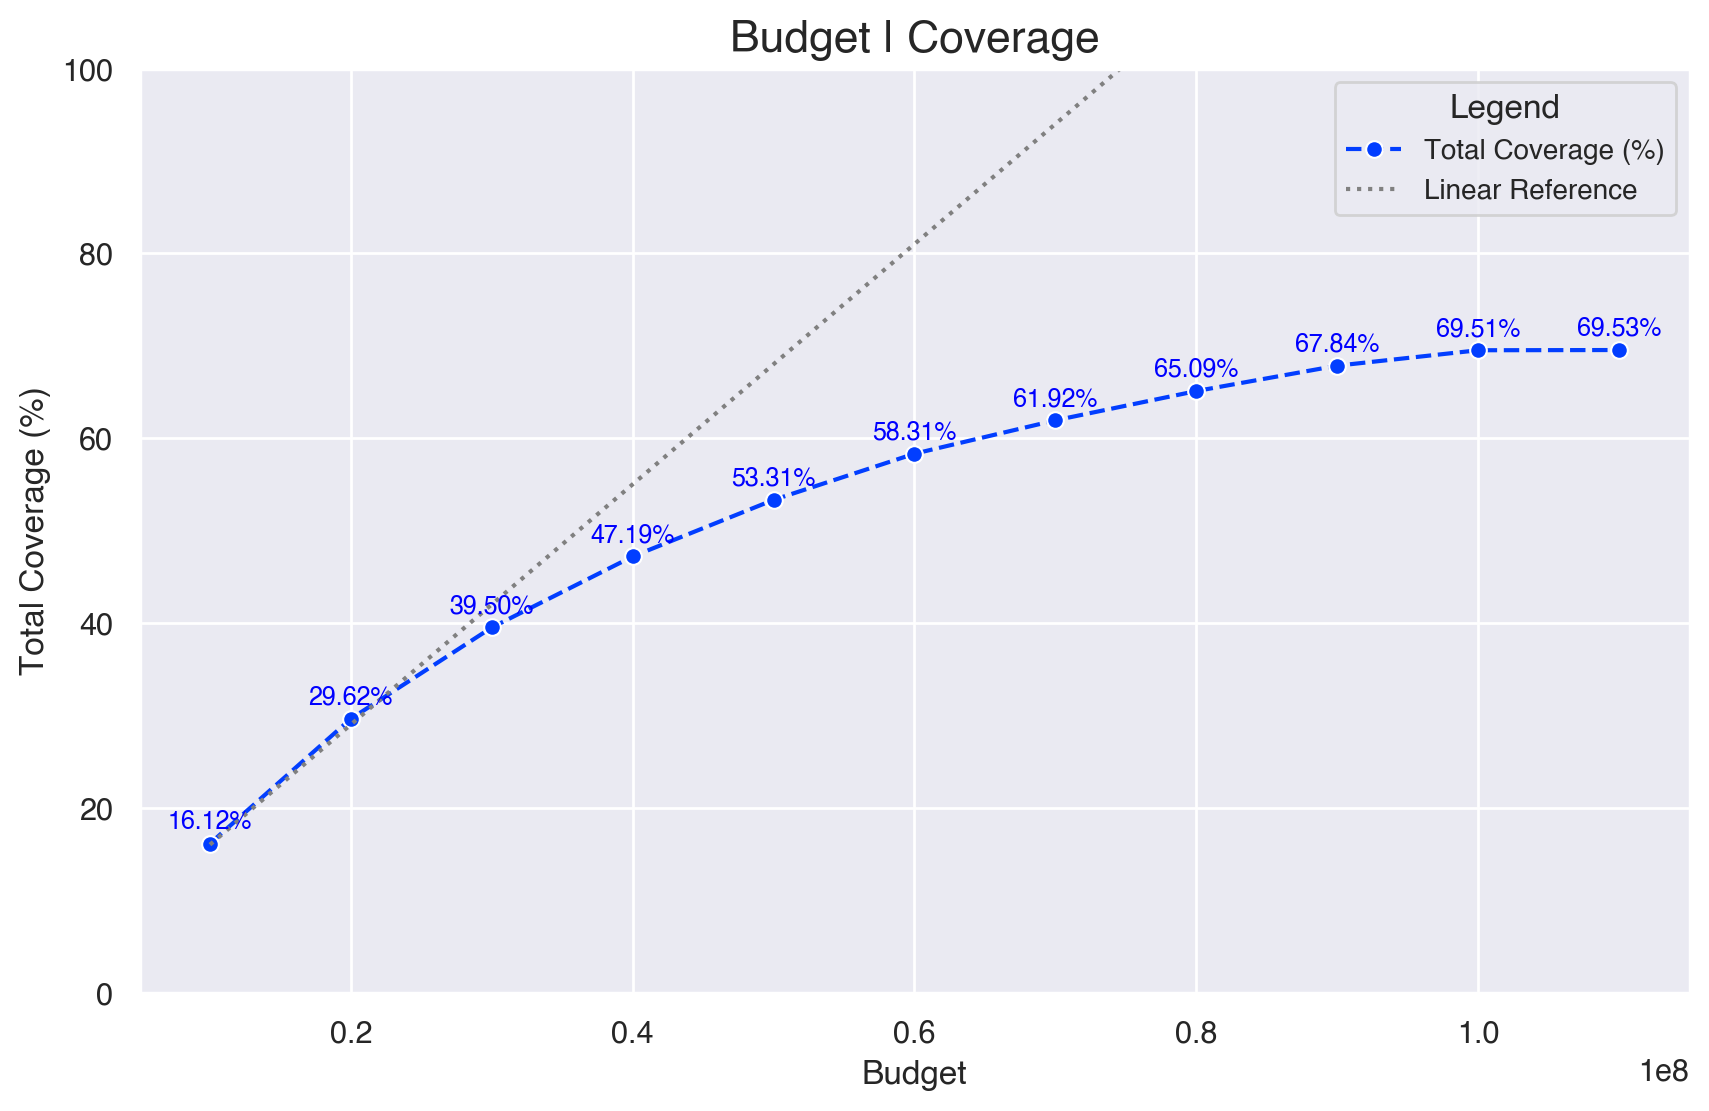

Plot saved as './data/ipynb_plots_saved/budget_total_coverage_curve_with_custom_reference.png'.


In [16]:
# Load results from JSON file
input_file = "./data/model_results_totals.json"
with open(input_file, "r") as f:
    results = json.load(f)

# Extract budgets and coverage percentages
budgets = [entry["budget"] for entry in results]
coverage_percentages = [entry["total_coverage_percentage"] for entry in results]

# Calculate the slope and intercept of the reference line
x1, y1 = 10000000, 16
x2, y2 = 20000000, 29
slope = (y2 - y1) / (x2 - x1)  # (y2 - y1) / (x2 - x1)
intercept = y1 - slope * x1  # y = mx + b -> b = y - mx

# Define the reference line function
reference_line = [slope * x + intercept for x in budgets]

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=budgets, y=coverage_percentages, marker="o", linestyle="--", label="Total Coverage (%)")

# Plot the reference line
sns.lineplot(x=budgets, y=reference_line, color="gray", linestyle=":", label="Linear Reference")

# Add values as dots and annotate with numerical values
for i, (x, y) in enumerate(zip(budgets, coverage_percentages)):
    plt.text(x, y + 1, f"{y:.2f}%", fontsize=9, ha='center', va='bottom', color='blue')  # Position slightly above

# Add titles and labels
plt.title("Budget | Coverage", fontsize=16)
plt.ylim(0, 100)
plt.xlabel("Budget", fontsize=12)
plt.ylabel("Total Coverage (%)", fontsize=12)

# Add legend
plt.legend(title="Legend", loc="best", fontsize=10)

# Save the plot as an image
output_plot_path = "./data/ipynb_plots_saved/budget_total_coverage_curve_with_custom_reference.png"
plt.savefig(output_plot_path, bbox_inches="tight", dpi=300)
plt.show()

print(f"Plot saved as '{output_plot_path}'.")


### Budget | Profit

In [157]:
# Load results from JSON file
input_file = "./data/model_results_totals.json"
with open(input_file, "r") as f:
    results = json.load(f)

# Extract budgets, absolute coverages, and percentages
budgets = [entry["budget"] for entry in results]
coverage_percentages = [entry["total_coverage_percentage"] for entry in results]
coverage_totals = [entry["total_demand_coverage"] for entry in results]


coverage_totals_s = pd.Series(coverage_totals)
budgets_s = pd.Series(budgets)

In [158]:
MILLION = 1000000

COEFFICIENT = 0.40
revenue = coverage_totals_s * COEFFICIENT / MILLION
cost = budgets_s / MILLION
profit = revenue - cost

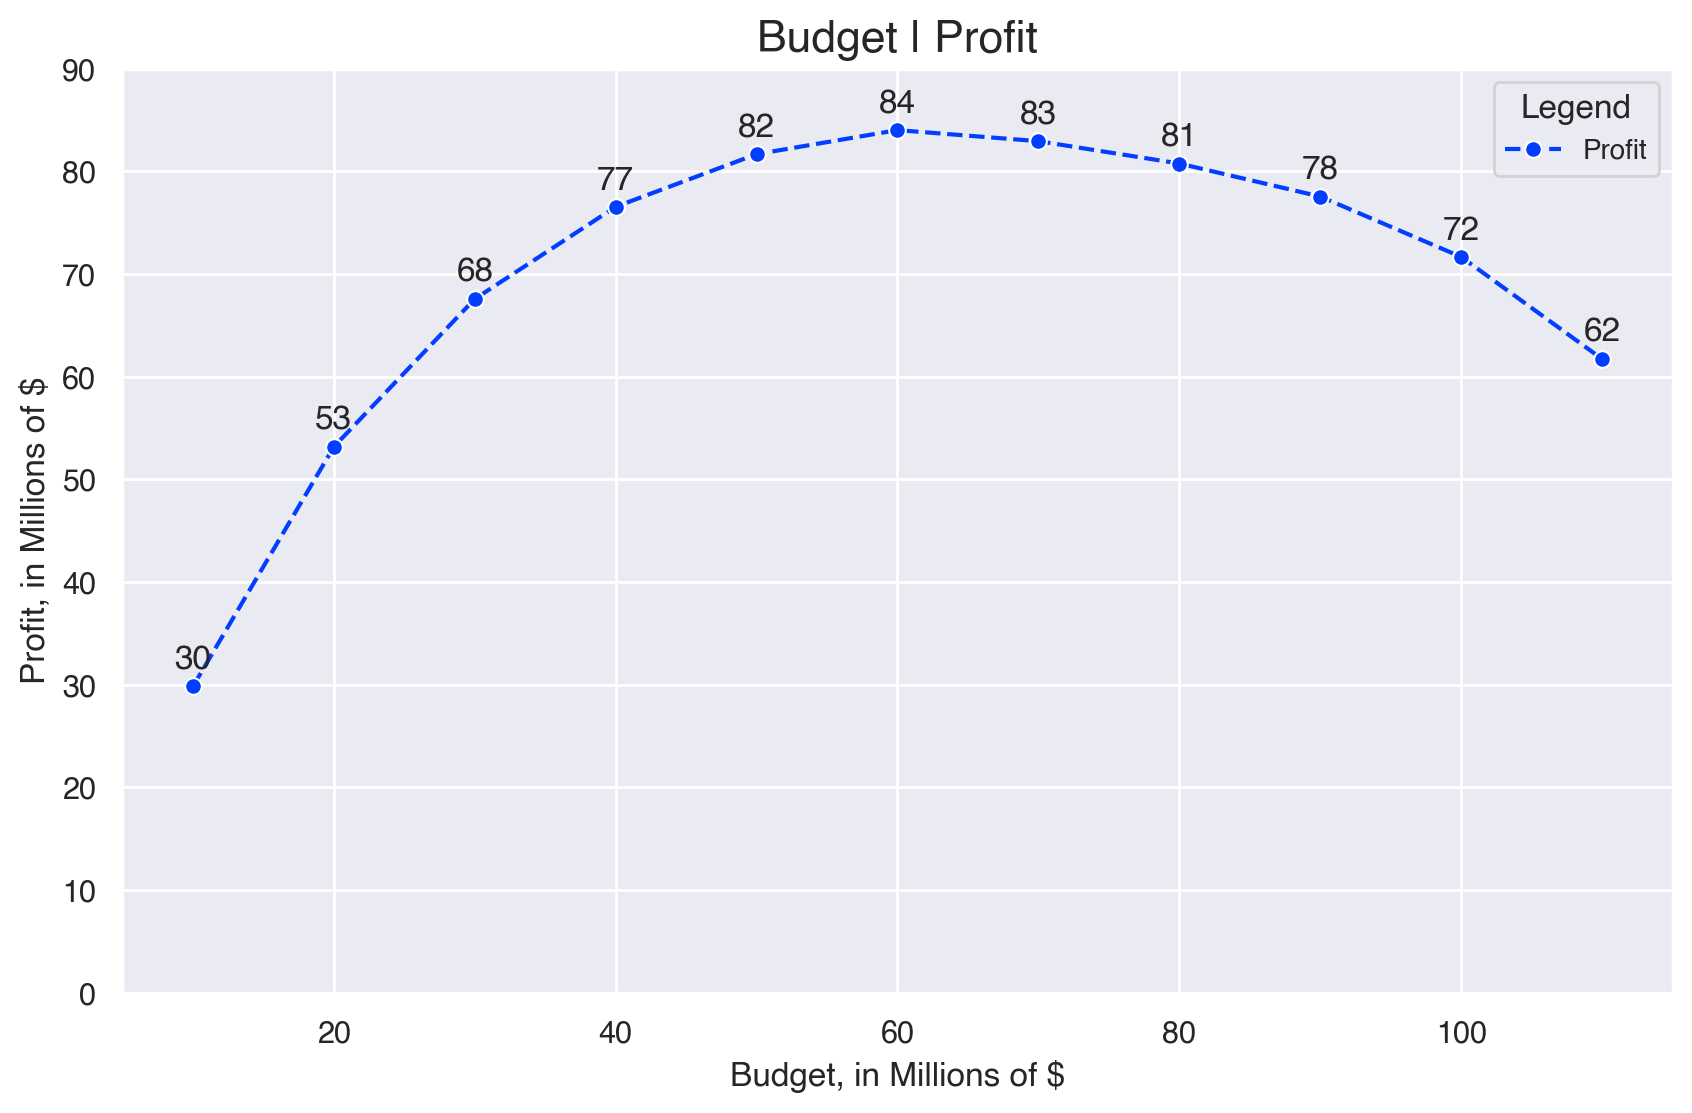

Plot saved as './data/ipynb_plots_saved/budget_total_coverage_curve_with_reference.png'.


In [159]:
# Create the plot
plt.figure(figsize=(10, 6))

sns.lineplot(x=cost, y=profit, marker="o", linestyle="--", label="Profit")

# Add values as dots and annotate with numerical values
for i, (x, y) in enumerate(zip(cost, profit)):
    plt.text(x, y + 1, f"{y:.0f}", fontsize=12, ha='center', va='bottom')  # Position slightly above

# Add titles and labels
plt.title("Budget | Profit", fontsize=16)
plt.xlabel("Budget, in Millions of $", fontsize=12)
plt.ylabel("Profit, in Millions of $", fontsize=12)
plt.ylim(0, 90)

# Add legend
plt.legend(title="Legend", loc="best", fontsize=10)

# Save the plot as an image
output_plot_path = "./data/ipynb_plots_saved/budget_total_coverage_curve_with_reference.png"
plt.savefig(output_plot_path, bbox_inches="tight", dpi=300)
plt.show()

print(f"Plot saved as '{output_plot_path}'.")

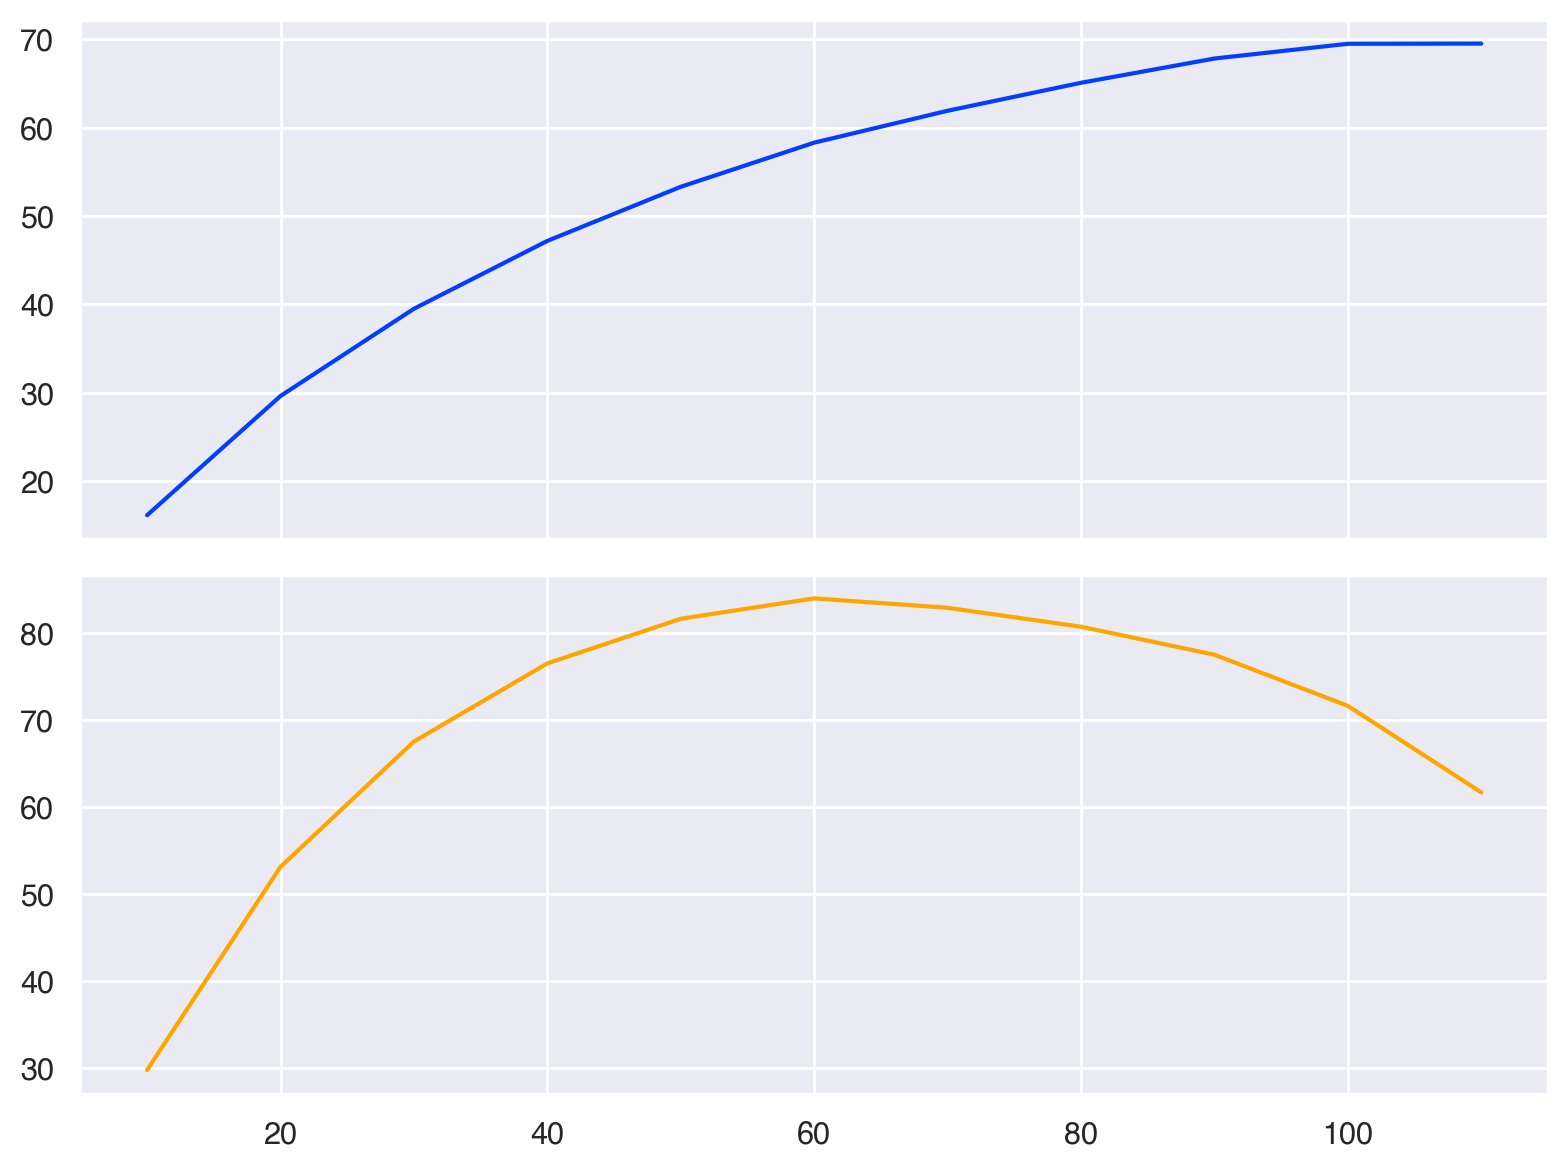

In [163]:
# Create subplots with shared x-axis
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# First plot
sns.lineplot(x=cost, y=coverage_percentages, ax=axes[0])

# Second plot
sns.lineplot(x=cost, y=profit, ax=axes[1], color="orange")

plt.tight_layout()
plt.show()

## Charger Placement

### Shapes

In [6]:
# Load the built stations data
with open("./data/model_output/built_stations.pkl", "rb") as f:
    built_stations = pickle.load(f)

# Map the built station data to the GeoDataFrame
gdf_built_stations = gdf_shp_areas.copy()
gdf_built_stations['chargers_built'] = gdf_built_stations['full_id'].map(built_stations).fillna(0)

# Filter out areas with no chargers
gdf_built_stations_nonzero = gdf_built_stations[gdf_built_stations['chargers_built'] > 0]

# Ensure the GeoDataFrame has the correct CRS (WGS84 for compatibility)
if gdf_built_stations_nonzero.crs is None or gdf_built_stations_nonzero.crs.to_string() != "EPSG:4326":
    gdf_built_stations_nonzero = gdf_built_stations_nonzero.to_crs(epsg=4326)

# Style the base layer with gray and transparency
base_style = {
    'fillColor': '#d3d3d3',  # Light gray color for the base map
    'fillOpacity': 0.1,      # Partial transparency
    'color': '#d3d3d3',      # Border color to match the fill
    'weight': 0.5            # Thin border for the areas
}

# Use the GeoPandas `explore` function to visualize with a blue palette
map_stations = gdf_shp_areas.explore(
    style_kwds=base_style,  # Style for the base layer
    tooltip=["full_id"],    # Tooltip for base layer areas
    popup=True              # Enable pop-ups for base layer info
)

# Add the stations layer with the blue palette on top of the base layer
stations_layer = gdf_built_stations_nonzero.explore(
    column="chargers_built",  # The column to visualize
    cmap="Purples",            # Blue color palette
    vmin=-5,                    # Start the color spectrum at 1 (to make it darker for low values)
    vmax=1,
    legend=True,             # Show legend
    legend_kwds={'caption': "Chargers Built"},  # Customize legend caption
    tooltip=["full_id", "chargers_built"],      # Show ID and chargers on hover
    popup=True,              # Enable pop-ups for detailed info
    m=map_stations           # Add to the existing map
)

# Save the map to an HTML file
output_path = "./data/maps/stations_built_map_shapes.html"
stations_layer.save(output_path)

print(f"Map created and saved as '{output_path}'.")


Map created and saved as './data/maps/stations_built_map_shapes.html'.


### Points

In [ ]:
# Load the built stations data
with open("./data/model_output/built_stations.pkl", "rb") as f:
    built_stations = pickle.load(f)

# Map the built station data to the GeoDataFrame
gdf_built_stations = gdf_shp_areas.copy()
gdf_built_stations['chargers_built'] = gdf_built_stations['full_id'].map(built_stations).fillna(0)

# Filter out areas with no chargers
gdf_built_stations_nonzero = gdf_built_stations[gdf_built_stations['chargers_built'] > 0]

# Ensure the GeoDataFrame has the correct CRS (WGS84 for compatibility)
if gdf_built_stations.crs is None or gdf_built_stations.crs.to_string() != "EPSG:4326":
    gdf_shp_areas = gdf_shp_areas.to_crs(epsg=4326)
    gdf_built_stations_nonzero = gdf_built_stations_nonzero.to_crs(epsg=4326)

# Calculate centroids for stations
gdf_built_stations_nonzero['centroid'] = gdf_built_stations_nonzero.geometry.centroid

# Create the base map
map_stations = folium.Map(
    location=[gdf_shp_areas.geometry.centroid.y.mean(), gdf_shp_areas.geometry.centroid.x.mean()],
    zoom_start=8
)

# Add transparent base layer for areas with interactivity
folium.GeoJson(
    gdf_shp_areas,
    style_function=lambda x: {
        'fillColor': '#d3d3d3',
        'fillOpacity': 0.4,
        'color': '#d3d3d3',
        'weight': 0.5
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['full_id'],  # Replace with the columns you want to show
        aliases=['Area ID:'],  # Alias for better readability
        localize=True
    ),
    popup=folium.GeoJsonPopup(
        fields=['full_id'],  # Replace with the columns you want to show in the popup
        aliases=['Area ID:'],  # Alias for better readability
        localize=True
    ),
    name='Base Layer'
).add_to(map_stations)

# Add jittered points for chargers
for _, row in gdf_built_stations_nonzero.iterrows():
    chargers = int(row['chargers_built'])  # Number of chargers
    centroid = row['centroid']
    
    # Generate jittered points around the centroid
    for _ in range(chargers):
        jitter_lat = centroid.y + random.uniform(-0.0030, 0.0030)  # Small jitter in latitude
        jitter_lon = centroid.x + random.uniform(-0.0030, 0.0030)  # Small jitter in longitude
        
        # Add the point to the map
        folium.CircleMarker(
            location=[jitter_lat, jitter_lon],
            radius=2,  # Small radius
            color='purple',
            fill=True,
            fill_color='purple',
            fill_opacity=0.8
        ).add_to(map_stations)

# Save the map to an HTML file
output_path = "./data/maps/stations_built_map_points.html"
map_stations.save(output_path)

print(f"Map created and saved as '{output_path}'.")


/var/folders/9q/6xd73j7x5tqg10w1v1xhrcl80000gn/T/ipykernel_18284/3492515622.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_built_stations_nonzero['centroid'] = gdf_built_stations_nonzero.geometry.centroid
/var/folders/9q/6xd73j7x5tqg10w1v1xhrcl80000gn/T/ipykernel_18284/3492515622.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=[gdf_shp_areas.geometry.centroid.y.mean(), gdf_shp_areas.geometry.centroid.x.mean()],


Map created and saved as './data/maps/stations_built_map_points.html'.


## Area Coverage

### Percentages

In [14]:
# Load the coverage percentages data
with open("./data/model_output/coverage_percentages.pkl", "rb") as f:
    coverage_percentages = pickle.load(f)

# Map the coverage data to the GeoDataFrame
gdf_coverage = gdf_shp_areas.copy()
gdf_coverage['coverage_percentage'] = gdf_coverage['full_id'].map(coverage_percentages).fillna(0)

# Ensure the GeoDataFrame has the correct CRS (WGS84 for compatibility)
if gdf_coverage.crs is None or gdf_coverage.crs.to_string() != "EPSG:4326":
    gdf_coverage = gdf_coverage.to_crs(epsg=4326)

# Style the base layer with gray and transparency
base_style = {
    'fillColor': '#d3d3d3',  # Light gray color for the base map
    'fillOpacity': 0.1,      # Partial transparency
    'color': '#d3d3d3',      # Border color to match the fill
    'weight': 0.5            # Thin border for the areas
}

# Use the GeoPandas `explore` function to visualize the base layer
map_coverage = gdf_shp_areas.explore(
    style_kwds=base_style,  # Style for the base layer
    tooltip=["full_id", "area_demand"],    # Tooltip for base layer areas
    popup=True              # Enable pop-ups for base layer info
)

gdf_coverage.coverage_percentage= gdf_coverage.coverage_percentage.astype(int)
# Add the area coverage layer with a green palette on top of the base layer
coverage_layer = gdf_coverage.explore(
    column="coverage_percentage",  # The column to visualize
    cmap="RdYlGn",                   # Yellow-Green color palette for coverage
    vmin=0,                        # Start at 0% coverage
    vmax=100,                      # Max coverage at 100%
    legend=True,                   # Show legend
    tooltip=["full_id", "coverage_percentage", "area_demand"],          # Show on hover
    popup=True,                   # Enable pop-ups for detailed info
    m=map_coverage                # Add to the existing map
)

# Save the map to an HTML file
output_path = "./data/maps/area_coverage_map_percentages_rg.html"
coverage_layer.save(output_path)

print(f"Map created and saved as '{output_path}'.")


Map created and saved as './data/maps/area_coverage_map_percentages_rg.html'.


### Absolutes

In [8]:
# Load the coverage percentages data
with open("./data/model_output/coverage_percentages.pkl", "rb") as f:
    coverage_percentages = pickle.load(f)

# Map the coverage data to the GeoDataFrame
gdf_coverage = gdf_shp_areas.copy()
gdf_coverage['coverage_percentage'] = gdf_coverage['full_id'].map(coverage_percentages).fillna(0)
gdf_coverage['coverage_absolute'] = ((gdf_coverage['coverage_percentage']/100) * gdf_coverage['area_demand']).astype(int)

# Ensure the GeoDataFrame has the correct CRS (WGS84 for compatibility)
if gdf_coverage.crs is None or gdf_coverage.crs.to_string() != "EPSG:4326":
    gdf_coverage = gdf_coverage.to_crs(epsg=4326)

# Style the base layer with gray and transparency
base_style = {
    'fillColor': '#d3d3d3',  # Light gray color for the base map
    'fillOpacity': 0.1,      # Partial transparency
    'color': '#d3d3d3',      # Border color to match the fill
    'weight': 0.5            # Thin border for the areas
}

# Use the GeoPandas `explore` function to visualize the base layer
map_coverage = gdf_shp_areas.explore(
    style_kwds=base_style,  # Style for the base layer
    tooltip=["full_id", "area_demand"],    # Tooltip for base layer areas
    popup=True              # Enable pop-ups for base layer info
)

gdf_coverage.coverage_percentage= gdf_coverage.coverage_percentage.astype(int)
vmax_value = gdf_coverage.coverage_absolute.quantile(0.8)
# Add the area coverage layer with a green palette on top of the base layer
coverage_layer = gdf_coverage.explore(
    column="coverage_absolute",  # The column to visualize
    cmap="YlGn",                   # Yellow-Green color palette for coverage
    vmin=0,                        
    vmax=vmax_value,               
    legend=True,                   # Show legend
    tooltip=["full_id", "coverage_absolute", "coverage_percentage", "area_demand"],          # Show on hover
    popup=True,                   # Enable pop-ups for detailed info
    m=map_coverage                # Add to the existing map
)

# Save the map to an HTML file
output_path = "./data/maps/area_coverage_map_absolutes.html"
coverage_layer.save(output_path)

print(f"Map created and saved as '{output_path}'.")


Map created and saved as './data/maps/area_coverage_map_absolutes.html'.


## Demand

In [13]:
# Style the base layer with gray and transparency
base_style = {
    'fillColor': '#d3d3d3',  # Light gray color for the base map
    'fillOpacity': 0.1,      # Partial transparency
    'color': '#d3d3d3',      # Border color to match the fill
    'weight': 0.5            # Thin border for the areas
}

# Use the GeoPandas `explore` function to visualize the base layer
map_coverage = gdf_shp_areas.explore(
    style_kwds=base_style,  # Style for the base layer
    tooltip=["full_id", "area_demand"],    # Tooltip for base layer areas
    popup=True              # Enable pop-ups for base layer info
)

gdf_shp_areas.area_demand = gdf_shp_areas.area_demand.astype(int)
vmax_value = gdf_shp_areas.area_demand.quantile(0.8)
# Add the area coverage layer with a green palette on top of the base layer
coverage_layer = gdf_shp_areas.explore(
    column="area_demand",  # The column to visualize
    cmap="Grays",                   
    vmin=0,                        
    vmax=vmax_value,               
    legend=True,                   # Show legend
    tooltip=["full_id", "area_demand"],          # Show on hover
    popup=True,                   # Enable pop-ups for detailed info
    m=map_coverage                # Add to the existing map
)

# Save the map to an HTML file
output_path = "./data/maps/areas_demand_map.html"
coverage_layer.save(output_path)

print(f"Map created and saved as '{output_path}'.")

Map created and saved as './data/maps/areas_demand_map.html'.


## Trips

routes served (for now its initial routes, they correlate a lot)

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon, LineString
import pandas as pd
import networkx as nx
import folium
from folium.features import GeoJson, GeoJsonTooltip
import pickle

# ----------------------------
# Step 1: Load Your GeoDataFrame and Data
# ----------------------------

# Load processed data
with open("./data/georgia_processed_data/georgia_processed_data.pkl", "rb") as f:
    loaded_data = pickle.load(f)

print("Loaded Data Keys:", loaded_data.keys())
A = loaded_data['areas']
P = loaded_data['potential_sites']
c = loaded_data['areas_demand']
tr = loaded_data['trips']

# Load the built stations data
with open("./data/model_output/built_stations.pkl", "rb") as f:
    built_stations = pickle.load(f)

# Assuming `gdf_shp_areas` is part of `loaded_data` or defined elsewhere
# Replace the following line with the actual way to obtain `gdf_shp_areas`
# gdf_shp_areas = loaded_data.get('gdf_shp_areas')  # Adjust as necessary

if gdf_shp_areas is None:
    raise ValueError("gdf_shp_areas not found in loaded_data. Please ensure it's correctly loaded.")

# Map the built station data to the GeoDataFrame
gdf_built_stations = gdf_shp_areas.copy()
gdf_built_stations['chargers_built'] = gdf_built_stations['full_id'].map(built_stations).fillna(0)

# Filter out areas with no chargers
gdf_built_stations_nonzero = gdf_built_stations[gdf_built_stations['chargers_built'] > 0]

# Ensure the GeoDataFrame has the correct CRS (WGS84 for compatibility)
if gdf_built_stations_nonzero.crs is None or gdf_built_stations_nonzero.crs.to_string() != "EPSG:4326":
    gdf_built_stations_nonzero = gdf_built_stations_nonzero.to_crs(epsg=4326)

# ----------------------------
# Step 2: Convert `tr` Dictionary to DataFrame
# ----------------------------

# Convert the dictionary to a DataFrame
tr_df = pd.DataFrame(
    [(from_id, to_id, weight) for (from_id, to_id), weight in tr.items()],
    columns=['from_id', 'to_id', 'weight']
)

print("\nConnection DataFrame (tr_df):")
print(tr_df.head())

# ----------------------------
# Step 3: Merge `tr_df` with `gdf_shp_areas`
# ----------------------------

# Merge to get geometry for 'from_id'
tr_merged = tr_df.merge(
    gdf_shp_areas[['full_id', 'geometry']],
    left_on='from_id',
    right_on='full_id',
    how='left'
).rename(columns={'geometry': 'from_geometry'})

# Merge to get geometry for 'to_id'
tr_merged = tr_merged.merge(
    gdf_shp_areas[['full_id', 'geometry']],
    left_on='to_id',
    right_on='full_id',
    how='left'
).rename(columns={'geometry': 'to_geometry'})

# Drop redundant 'full_id' columns after merge
tr_merged = tr_merged.drop(['full_id_x', 'full_id_y'], axis=1)

print("\nMerged Connection DataFrame (tr_merged):")
print(tr_merged.head())

# ----------------------------
# Step 4: Handle Missing Geometries
# ----------------------------

# Check for any missing geometries
missing_from = tr_merged[tr_merged['from_geometry'].isnull()]
missing_to = tr_merged[tr_merged['to_geometry'].isnull()]

if not missing_from.empty or not missing_to.empty:
    print("\nWarning: Some connections have missing geometries.")
    if not missing_from.empty:
        print("Missing 'from_geometry':")
        print(missing_from)
    if not missing_to.empty:
        print("Missing 'to_geometry':")
        print(missing_to)
    # Handle accordingly, e.g., remove these rows
    tr_merged = tr_merged.dropna(subset=['from_geometry', 'to_geometry'])

# ----------------------------
# Step 5: Keep Only Top 5 Trips per `from_id` by `weight`
# ----------------------------

# Sort the DataFrame by 'from_id' and 'weight' in descending order
tr_merged_sorted = tr_merged.sort_values(['from_id', 'weight'], ascending=[True, False])

# Group by 'from_id' and take the top 5 'to_id's by 'weight'
tr_merged_top5 = tr_merged_sorted.groupby('from_id').head(5).reset_index(drop=True)

print("\nFiltered Connection DataFrame (tr_merged_top5):")
print(tr_merged_top5.head())

# ----------------------------
# Step 6: Create a NetworkX Graph with All Relevant Nodes
# ----------------------------

# Initialize an undirected graph
G = nx.Graph()

# Add all unique 'from_id's and 'to_id's with their geometries
from_geometries = tr_merged_top5.set_index('from_id')['from_geometry']
to_geometries = tr_merged_top5.set_index('to_id')['to_geometry']

# Add 'from_id' nodes
for from_id, geometry in from_geometries.items():
    if not G.has_node(from_id):
        G.add_node(from_id, geometry=geometry)

# Add 'to_id' nodes
for to_id, geometry in to_geometries.items():
    if not G.has_node(to_id):
        G.add_node(to_id, geometry=geometry)

# Add edges with weights from the filtered DataFrame
for idx, row in tr_merged_top5.iterrows():
    G.add_edge(row['from_id'], row['to_id'], weight=row['weight'])

# ----------------------------
# Step 7: Prepare Data for Visualization
# ----------------------------

# Create a mapping from full_id to centroid coordinates
centroid_coords = {}
for node, data in G.nodes(data=True):
    geometry = data.get('geometry')
    if geometry is not None:
        centroid = geometry.centroid
        centroid_coords[node] = (centroid.y, centroid.x)  # (latitude, longitude)
    else:
        print(f"Warning: Node {node} has no geometry.")

# ----------------------------
# Step 8: Initialize Folium Map
# ----------------------------

# Calculate the central point for initializing the map
central_lat = gdf_built_stations_nonzero.geometry.centroid.y.mean()
central_lon = gdf_built_stations_nonzero.geometry.centroid.x.mean()

# Initialize the Folium map
m = folium.Map(location=[central_lat, central_lon], zoom_start=12, tiles='OpenStreetMap')

# ----------------------------
# Step 9: Add Station Polygons to the Map
# ----------------------------

# Define a style for the polygons
def style_function(feature):
    return {
        'fillColor': 'purple',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5,
    }

# Add polygons to the map without 'chargers_built' in tooltips
folium.GeoJson(
    gdf_built_stations_nonzero.drop(columns=['chargers_built']),
    style_function=style_function,
    tooltip=GeoJsonTooltip(fields=['full_id'],
                           aliases=['Station ID:'],
                           localize=True)
).add_to(m)

# ----------------------------
# Step 10: Calculate Quantiles for Weight Capping
# ----------------------------

# Determine quantiles to cap extreme weights
lower_quantile = 0.05
upper_quantile = 0.95

if not tr_merged_top5.empty:
    min_weight = tr_merged_top5['weight'].quantile(lower_quantile)
    max_weight = tr_merged_top5['weight'].quantile(upper_quantile)
    print(f"\nWeight Quantiles: {lower_quantile*100}% = {min_weight}, {upper_quantile*100}% = {max_weight}")
else:
    min_weight = max_weight = 1  # Default values to prevent division by zero

# ----------------------------
# Step 11: Define a Function to Map Weight to Line Thickness
# ----------------------------

def map_weight_to_thickness(weight, min_w, max_w, min_thick=1, max_thick=5):
    """
    Maps a weight value to a line thickness, capping it between min_thick and max_thick
    based on the provided min and max weights.
    """
    # Cap the weight
    if weight < min_w:
        weight = min_w
    elif weight > max_w:
        weight = max_w
    # Normalize the weight
    normalized = (weight - min_w) / (max_w - min_w) if max_w != min_w else 0.5
    # Scale to thickness range
    thickness = min_thick + normalized * (max_thick - min_thick)
    return thickness

# ----------------------------
# Step 12: Add Edges (Connections) to the Map
# ----------------------------


# Add edges as PolyLines with thickness based on weight
for edge in G.edges(data=True):
    from_id, to_id, data = edge
    weight = data['weight']
    # Get coordinates
    from_coord = centroid_coords.get(from_id)
    to_coord = centroid_coords.get(to_id)
    if from_coord and to_coord:
        # Map weight to thickness with capping
        thickness = map_weight_to_thickness(weight, min_weight, max_weight)
        folium.PolyLine(
            locations=[(from_coord[0], from_coord[1]), (to_coord[0], to_coord[1])],
            color='blue',
            weight=thickness,
            opacity=0.3,
            tooltip=f'Weight: {weight}'
        ).add_to(m)

        # Add points at both ends of the line
        folium.CircleMarker(
            location=to_coord,
            radius=thickness/10, # doesnt change anything
            color='purple',
            fill=True,
            fill_opacity=0.05
        ).add_to(m)
    else:
        print(f"Warning: Missing coordinates for edge ({from_id}, {to_id})")

# ----------------------------
# Step 13: Save and Display the Map
# ----------------------------

# Save the map to an HTML file
m.save("./data/maps/built_stations_graph_map_top5_only_lines.html")
print("\nMap has been saved to 'built_stations_graph_map_top5_only_lines.html'. Open this file in a web browser to view the visualization.")

# If you're using a Jupyter Notebook, display the map inline by uncommenting the following line:
# m




Loaded Data Keys: dict_keys(['trips', 'potential_sites', 'areas', 'areas_demand'])

Connection DataFrame (tr_df):
        from_id         to_id  weight
0  131299706022  130131803011      82
1  131299706022  130159601011     504
2  131299706022  130159601041     436
3  131299706022  130159601042     575
4  131299706022  130159601051     492

Merged Connection DataFrame (tr_merged):
        from_id         to_id  weight  \
0  131299706022  130131803011      82   
1  131299706022  130159601011     504   
2  131299706022  130159601041     436   
3  131299706022  130159601042     575   
4  131299706022  130159601051     492   

                                       from_geometry  \
0  POLYGON ((-84.98091 34.46298, -84.98050 34.463...   
1  POLYGON ((-84.98091 34.46298, -84.98050 34.463...   
2  POLYGON ((-84.98091 34.46298, -84.98050 34.463...   
3  POLYGON ((-84.98091 34.46298, -84.98050 34.463...   
4  POLYGON ((-84.98091 34.46298, -84.98050 34.463...   

                                